### Question 1 (20%)
Load the energy data from the file `Energy Indicators.xls`, which is a list of indicators of [energy supply and renewable electricity production](Energy%20Indicators.xls) from the [United Nations](http://unstats.un.org/unsd/environment/excel_file_tables/2013/Energy%20Indicators.xls) for the year 2013, and should be put into a DataFrame with the variable name of **energy**.

Keep in mind that this is an Excel file, and not a comma separated values file. Also, make sure to exclude the footer and header information from the datafile. The first two columns are unneccessary, so you should get rid of them, and you should change the column labels so that the columns are:

`['Country', 'Energy Supply', 'Energy Supply per Capita', '% Renewable']`

Convert `Energy Supply` to gigajoules (there are 1,000,000 gigajoules in a petajoule). For all countries which have missing data (e.g. data with "...") make sure this is reflected as `np.NaN` values.

Rename the following list of countries (for use in later questions):

```"Republic of Korea": "South Korea",
"United States of America": "United States",
"United Kingdom of Great Britain and Northern Ireland": "United Kingdom",
"China, Hong Kong Special Administrative Region": "Hong Kong"```

There are also several countries with numbers and/or parenthesis in their name. Be sure to remove these, 

e.g. 

`'Bolivia (Plurinational State of)'` should be `'Bolivia'`, 

`'Switzerland17'` should be `'Switzerland'`.

<br>

Next, load the GDP data from the file `world_bank.csv`, which is a csv containing countries' GDP from 1960 to 2015 from [World Bank](http://data.worldbank.org/indicator/NY.GDP.MKTP.CD). Call this DataFrame **GDP**. 

Make sure to skip the header, and rename the following list of countries:

```"Korea, Rep.": "South Korea", 
"Iran, Islamic Rep.": "Iran",
"Hong Kong SAR, China": "Hong Kong"```

<br>

Finally, load the [Sciamgo Journal and Country Rank data for Energy Engineering and Power Technology](http://www.scimagojr.com/countryrank.php?category=2102) from the file `scimagojr-3.xlsx`, which ranks countries based on their journal contributions in the aforementioned area. Call this DataFrame **ScimEn**.

Join the three datasets: GDP, Energy, and ScimEn into a new dataset (using the intersection of country names). Use only the last 10 years (2006-2015) of GDP data and only the top 15 countries by Scimagojr 'Rank' (Rank 1 through 15). 

The index of this DataFrame should be the name of the country, and the columns should be ['Rank', 'Documents', 'Citable documents', 'Citations', 'Self-citations',
       'Citations per document', 'H index', 'Energy Supply',
       'Energy Supply per Capita', '% Renewable', '2006', '2007', '2008',
       '2009', '2010', '2011', '2012', '2013', '2014', '2015'].

*This function should return a DataFrame with 20 columns and 15 entries.*

In [149]:
import pandas as pd
import numpy as np
import os
import re

In [198]:
# Function to make Corrections 
def dic_corrections(x):
    '''
    1. Applies corrections stored in a dictionary to a string 
    2. Remove parts of string, if any in parentheses, and any numbers in the string
    
    '''
    cor_dic = {"South Korea" : [["Republic", 'Korea'], ["Rep.", 'Korea']],
            "United States" : [["United", "States", "America"], ],
            "United Kingdom" : [["United", "Kingdom", "Britain"], ["Northern", "Ireland"]] ,
            "Hong Kong"  : [['China',"Hong" ,"Kong"],],
            "Iran" : [["Iran",],]}
    try:
        lt_words = x.replace(',', '').split(sep = ' ')
        #print(lt_words)
        for k,vals in cor_dic.items():
            #print(k, vals)
            for lt in vals:
                check = all([el in lt_words for el in lt])
                #print(check, k, '\n')
                if(check & (k != 'South Korea')):
                    return(k)
                elif(check & (k == 'South Korea') & (len(lt_words) < 4)):
                    return(k)
                else:
                    continue
        return(x)        
    except:
        return(x)
    

def other_corrections(x):
    # partiton on '(' and extract 1st component of the resulting list
    #print(x)
    try:
        temp = re.search('\(', x,) 
        if(temp is not None):
            result = x[0: temp.start()]
        else:
            result = x
        #print(result)    
        m = re.search('[0-9]+', result)  
        if(m is not None):
            result_fin = result.replace(result[m.start(): m.end()], '')
        else:
            result_fin = result
        return result_fin.strip()    
        #print(result)
    except TypeError:
        return x
   
    
def correct(x):
    temp = other_corrections(x)
    result = dic_corrections(temp)
    #print(x, temp,result)
    return(result) 

def read_frame(path):
    '''Read xls file from hard drive'''

    with pd.ExcelFile(path) as con:
        energy = pd.read_excel(io = path, sheetname = 'Energy',skiprows = 18, 
                            header = None, index_col = None,
                           names = ['Country', 'Energy Supply', 'Energy Supply per Capita', '% Renewable'],
                           dtype = {'Country' : 'str', 
                                    'Energy Suply' : np.float64,  # will work even is NaN are there, as NaN is float
                                    'Energy Supply per Capita' : np.float64,
                                    '% Renewable' : np.float64},
                           # converters = {'Energy Supply' : peta_to_giga, },
                            parse_cols = "C:F", 
                            na_values = ['', 'NA', None, '...'], 
                            verbose = True,)
    #print(energy.head())  
    #energy = energy.loc[~np.isnan(energy['Country']),].copy()
    energy['Country_new'] = energy['Country'].map(correct)
    energy.drop('Country',axis= 1, inplace= True)
    energy.set_index('Country_new',inplace= True)
    # Conversion of gigaJ to petaJ    
    energy['Energy Supply(GJ)'] = energy['Energy Supply'].map(lambda x : x*1000000) 
    energy.drop('Energy Supply', axis= 1,inplace = True)
    energy.dropna(axis = 0, how = 'all',inplace = True) # drop empty rows
    return(energy)

def download_frames(urls):
    'Downloads two files from web, makes modifications, and returns them as data frames'
    import io
    from zipfile import ZipFile
    import requests
    
    ### First file, zipped file ###
    
    ## pd.read_csv -  Has a provision for reading a zipped file but only when there is single file zipped ##
    ## Read specific csv from zipped file without downloading the full zipped directory ##
    
    response = requests.get(urls[0]) # get response
    zp = ZipFile(io.BytesIO(response.content)) # in memory stream of bytes is given to Zipfile
    zp.extract(path = os.getcwd() , member = zp.namelist()[1]) # extract specific file
    
    GDP = pd.read_csv(filepath_or_buffer= os.getcwd() + '/' + zp.namelist()[1],skiprows= 4, 
                  header = 0, index_col= None, 
                  usecols = ['Country Name', '2006', '2007', '2008', '2009', 
                             '2010', '2011', '2012', '2013', '2014', '2015'],
                 na_values = [''])
    
    GDP['Country_new'] = GDP['Country Name'].map(correct)
    # print(gdp.loc[gdp['Country_new'].map(lambda x: x.startswith('Iran')),])
    GDP.drop('Country Name',axis= 1, inplace= True)
    GDP.set_index('Country_new',inplace= True)
    
    ### Second File, an excel file ###
    response = requests.get(urls[1])
    with open('sjr.xls', 'wb') as con:
        con.write(response.content)
    ScimEn_pre = pd.read_excel(io = os.getcwd() + '/' + 'sjr.xls', header = 0)  
    # print(ScimEn.head())
    ScimEn = ScimEn_pre.set_index('Country',inplace= False).sort_values('Rank', inplace = False)
    
    dic_frames = {'GDP' : GDP , 'ScimEn' : ScimEn }
    return(dic_frames)

def check_dup_index(df):
    pass

def merge_frames(dic_frames):
    left_frame = dic_frames["GDP"]
    right_frame = dic_frames['energy']
    frame_1 = pd.merge(left_frame, right_frame, how = 'inner',
                                left_index= True,right_index = True)
   
    result = pd.merge(frame_1, dic_frames['ScimEn'], how = 'inner',
                                left_index= True,right_index = True)
    
    return(result)    

### Read 1st file

In [199]:
#path = os.getcwd() + "\\Data\\Energy Indicators.xls"
path = os.getcwd() + "/Energy Indicators.xls"
energy = read_frame(path)

Reading sheet Energy


In [200]:
def answer_one():
    df_final = merge_frames(dic_frames).sort_values('Rank')[0:15]
    return df_final

In [201]:
df = answer_one()
len(df.columns)

20

In [179]:
#energy.head()

### Read two files from web, merge frames

In [202]:
# Get data from web 
url1 = 'http://api.worldbank.org/v2/en/indicator/NY.GDP.MKTP.CD?downloadformat=csv'
url2 = 'https://www.scimagojr.com/countryrank.php?category=2102&out=xls'
urls = [url1, url2]
dic_frames = download_frames(urls)
dic_frames.update({'energy' : energy})
df = merge_frames(dic_frames)

### Question 2 (6.6%)
The previous question joined three datasets then reduced this to just the top 15 entries. When you joined the datasets, but before you reduced this to the top 15 items, how many entries did you lose?

*This function should return a single number.*

In [9]:
%%HTML
<svg width="800" height="300">
  <circle cx="150" cy="180" r="80" fill-opacity="0.2" stroke="black" stroke-width="2" fill="blue" />
  <circle cx="200" cy="100" r="80" fill-opacity="0.2" stroke="black" stroke-width="2" fill="red" />
  <circle cx="100" cy="100" r="80" fill-opacity="0.2" stroke="black" stroke-width="2" fill="green" />
  <line x1="150" y1="125" x2="300" y2="150" stroke="black" stroke-width="2" fill="black" stroke-dasharray="5,3"/>
  <text  x="300" y="165" font-family="Verdana" font-size="35">Everything but this!</text>
</svg>

In [203]:
def answer_two():
    a = set(dic_frames['energy'].index)
    b = set(dic_frames['GDP'].index)
    c = set(dic_frames['ScimEn'].index)
    x = a | b | c
    y = a & b & c
    
    return (len(x)- len(y))

In [204]:
answer_two()

144

## Answer the following questions in the context of only the top 15 countries by Scimagojr Rank (aka the DataFrame returned by `answer_one()`)

### Question 3 (6.6%)
What is the average GDP over the last 10 years for each country? (exclude missing values from this calculation.)

*This function should return a Series named `avgGDP` with 15 countries and their average GDP sorted in descending order.*

In [205]:
def avg_nonan(x):
    #a = np.ma.array(x, mask = np.isnan(x))
    a = x[~np.isnan(x)]
    return np.sum(a)/len(a)

def answer_three():
    Top15 = answer_one()
    cols = [str(x) for x in list(range(2006,2016))]
    avgGDP = Top15.loc[:,cols].apply(func = avg_nonan, axis = 1).sort_values(ascending = False)
    return avgGDP

In [183]:
#answer_one() 
#avg_nonan(pd.Series({'a': 3, 'b' :4, 'c' : np.nan}))

In [206]:
answer_three().index[5,]

'France'

### Question 4 (6.6%)
By how much had the GDP changed over the 10 year span for the country with the 6th largest average GDP?

*This function should return a single number.*

In [207]:
def answer_four():
    Top15 = answer_one()
    gdp_rk_6 = answer_three().index[5]
    ANSWER = Top15.loc[gdp_rk_6,'2015'] - Top15.loc[gdp_rk_6,'2006']
    return ANSWER

In [208]:
answer_four()

119614244263.37988

### Question 5 (6.6%)
What is the mean `Energy Supply per Capita`?

*This function should return a single number.*

In [209]:
def answer_five():
    Top15 = answer_one()
    ANSWER = avg_nonan(Top15['Energy Supply per Capita'])
    return ANSWER

In [210]:
answer_five()

157.6

### Question 6 (6.6%)
What country has the maximum % Renewable and what is the percentage?

*This function should return a tuple with the name of the country and the percentage.*

In [211]:
def nonan(x):
    #a = np.ma.array(x, mask = np.isnan(x))
    a = x[~np.isnan(x)]
    return a

def answer_six():
    Top15 = answer_one()
    a = nonan(Top15['% Renewable'])
    mx = np.max(a)
    nm = np.argmax(a)
    return (nm,mx)

In [212]:
answer_six()

('Brazil', 69.648030000000006)

### Question 7 (6.6%)
Create a new column that is the ratio of Self-Citations to Total Citations. 
What is the maximum value for this new column, and what country has the highest ratio?

*This function should return a tuple with the name of the country and the ratio.*

In [213]:
def answer_seven():
    Top15 = answer_one()
    Top15['ratio'] = Top15['Self-citations']/Top15['Citations']
    mx = np.max(Top15['ratio'])
    nm = np.argmax(Top15['ratio'])
    
    return (nm,mx)

In [214]:
answer_seven()

('China', 0.68320748544381471)

### Question 8 (6.6%)

Create a column that estimates the population using Energy Supply and Energy Supply per capita. 
What is the third most populous country according to this estimate?

*This function should return a single string value.*

In [195]:
df.columns

Index(['2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014',
       '2015', 'Energy Supply per Capita', '% Renewable', 'Energy Suppply(GJ)',
       'Rank', 'Documents', 'Citable documents', 'Citations', 'Self-citations',
       'Citations per document', 'H index'],
      dtype='object')

In [215]:
def answer_eight():
    Top15 = answer_one()
    Top15['Pop'] = Top15['Energy Supply(GJ)'] / Top15['Energy Supply per Capita'] 
    temp = nonan(Top15['Pop']).sort_values(ascending = False)
    ANSWER = temp.index[2]
    return ANSWER

In [216]:
answer_eight()

'United States'

### Question 9 (6.6%)
Create a column that estimates the number of citable documents per person. 
What is the correlation between the number of citable documents per capita and the energy supply per capita? Use the `.corr()` method, (Pearson's correlation).

*This function should return a single number.*

*(Optional: Use the built-in function `plot9()` to visualize the relationship between Energy Supply per Capita vs. Citable docs per Capita)*

In [217]:
def answer_nine():
    Top15 = answer_one()
    Top15['Pop'] = Top15['Energy Supply(GJ)'] / Top15['Energy Supply per Capita']
    Top15['ESPC'] = Top15['Energy Supply(GJ)'] / Top15['Pop']
    Top15['CDPC'] = Top15['Citable documents'] / Top15['Pop']
    ANSWER = Top15.loc[:,['ESPC', 'CDPC']].corr(method = 'pearson')
    return ANSWER.iloc[0,1]

In [218]:
answer_nine()

0.77404323399911701

In [221]:
def plot9():
    import matplotlib as plt
    %matplotlib inline
    
    Top15 = answer_one()
    Top15['Pop'] = Top15['Energy Supply(GJ)'] / Top15['Energy Supply per Capita']
    Top15['CDPC'] = Top15['Citable documents'] / Top15['Pop']
    Top15['ESPC'] = Top15['Citable documents'] / Top15['Pop']
    Top15.plot(x='CDPC', y='ESPC', kind='scatter', xlim=[0, 0.0006])

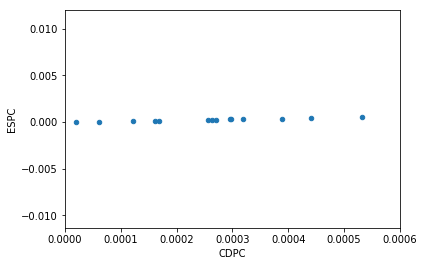

In [222]:
plot9() # Be sure to comment out plot9() before submitting the assignment!

### Question 10 (6.6%)
Create a new column with a 1 if the country's % Renewable value is at or above the median for all countries in the top 15, and a 0 if the country's % Renewable value is below the median.

*This function should return a series named `HighRenew` whose index is the country name sorted in ascending order of rank.*

In [223]:
def answer_ten():
    Top15 = answer_one()
    a = nonan(Top15['% Renewable'])
    med = np.median(a)
    Top15['HighRenew_temp'] = Top15['% Renewable'].where(Top15['% Renewable'] >= med,0)
    Top15['HighRenew'] = Top15['HighRenew_temp'].where(Top15['HighRenew_temp'] == 0,1)
    ANSWER = Top15['HighRenew']
    return ANSWER.sort_values(ascending = True)

In [224]:
answer_ten()

United States         0.0
Japan                 0.0
United Kingdom        0.0
India                 0.0
South Korea           0.0
Iran                  0.0
Australia             0.0
China                 1.0
Germany               1.0
Russian Federation    1.0
Canada                1.0
France                1.0
Italy                 1.0
Brazil                1.0
Spain                 1.0
Name: HighRenew, dtype: float64

### Question 11 (6.6%)
Use the following dictionary to group the Countries by Continent, then create a dateframe that displays the sample size (the number of countries in each continent bin), and the sum, mean, and std deviation for the estimated population of each country.

```python
ContinentDict  = {'China':'Asia', 
                  'United States':'North America', 
                  'Japan':'Asia', 
                  'United Kingdom':'Europe', 
                  'Russian Federation':'Europe', 
                  'Canada':'North America', 
                  'Germany':'Europe', 
                  'India':'Asia',
                  'France':'Europe', 
                  'South Korea':'Asia', 
                  'Italy':'Europe', 
                  'Spain':'Europe', 
                  'Iran':'Asia',
                  'Australia':'Australia', 
                  'Brazil':'South America'}
```

*This function should return a DataFrame with index named Continent `['Asia', 'Australia', 'Europe', 'North America', 'South America']` and columns `['size', 'sum', 'mean', 'std']`*

In [225]:
ContinentDict  = {'China':'Asia', 
                  'United States':'North America', 
                  'Japan':'Asia', 
                  'United Kingdom':'Europe', 
                  'Russian Federation':'Europe', 
                  'Canada':'North America', 
                  'Germany':'Europe', 
                  'India':'Asia',
                  'France':'Europe', 
                  'South Korea':'Asia', 
                  'Italy':'Europe', 
                  'Spain':'Europe', 
                  'Iran':'Asia',
                  'Australia':'Australia', 
                  'Brazil':'South America'}
def answer_eleven():
    Top15 = answer_one()
    Top15['Pop'] = Top15['Energy Supply(GJ)'] / Top15['Energy Supply per Capita']
    Continent = pd.Series(ContinentDict, index = ContinentDict.keys())
    Top15['Continent'] = Continent
    ANSWER = (Top15.loc[:,['Continent','Pop']].groupby('Continent',squeeze = True)
                  .agg({'Pop' :{'sum': np.sum, 
                                'mean':np.average, 
                                'std'  :np.std,
                                'size' : 'count'}}))
              #.set_index('Continent'))
    ANSWER.columns = ANSWER.columns.droplevel(0)                               
    
    return ANSWER

In [226]:
answer_eleven()

/Users/sumad/anaconda3/lib/python3.6/site-packages/pandas/core/groupby.py:4036: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


,sum,mean,std,size
Continent,,,,
Asia,2.898666e+09,5.797333e+08,6.790979e+08,5
Australia,2.331602e+07,2.331602e+07,NaN,1
Europe,4.579297e+08,7.632161e+07,3.464767e+07,6
North America,3.528552e+08,1.764276e+08,1.996696e+08,2
South America,2.059153e+08,2.059153e+08,NaN,1


### Question 12 (6.6%)
Cut % Renewable into 5 bins. Group Top15 by the Continent, as well as these new % Renewable bins. How many countries are in each of these groups?

*This function should return a __Series__ with a MultiIndex of `Continent`, then the bins for `% Renewable`. Do not include groups with no countries.*

In [227]:
#df.reset_index()

In [228]:
def answer_twelve():
    Top15 = answer_one()
    Top15['Cut'] = pd.cut(Top15['% Renewable'],bins= 5,right= True,include_lowest= False)
    Continent = pd.Series(ContinentDict, index = ContinentDict.keys())
    Top15['Continent'] = Continent
    grps = Top15.reset_index().groupby(['Continent','Cut']).size()
    '''
    dic = {}
    for k, grp in grps:
        ctries = len(grp['index'].unique())
        if(ctries > 0):
            dic[k] = ctries
    #df[d]
    #df = Top15.reset_index()
    return pd.Series(dic, index = dic.keys())
    '''
    return grps

In [229]:
answer_twelve()

Continent      Cut             
Asia           (2.212, 15.753]     4
               (15.753, 29.227]    1
Australia      (2.212, 15.753]     1
Europe         (2.212, 15.753]     1
               (15.753, 29.227]    3
               (29.227, 42.701]    2
North America  (2.212, 15.753]     1
               (56.174, 69.648]    1
South America  (56.174, 69.648]    1
dtype: int64

### Question 13 (6.6%)
Convert the Population Estimate series to a string with thousands separator (using commas). Do not round the results.

e.g. 317615384.61538464 -> 317,615,384.61538464

*This function should return a Series `PopEst` whose index is the country name and whose values are the population estimate string.*

In [231]:
def answer_thirteen():
    Top15 = answer_one()
    Top15['PopEst'] = Top15['Energy Supply(GJ)'] / Top15['Energy Supply per Capita']
    ANSWER = Top15['PopEst'].map(lambda x: '{0:,}'.format(x)).astype(str)
    return ANSWER

In [232]:
answer_thirteen()

China                 1,367,645,161.2903225
United States          317,615,384.61538464
Japan                  127,409,395.97315437
United Kingdom         63,870,967.741935484
India                 1,276,730,769.2307692
Germany                 80,369,696.96969697
Russian Federation            143,500,000.0
Canada                  35,239,864.86486486
France                  63,837,349.39759036
South Korea            49,805,429.864253394
Italy                  59,908,256.880733944
Iran                    77,075,630.25210084
Brazil                 205,915,254.23728815
Australia              23,316,017.316017315
Spain                    46,443,396.2264151
Name: PopEst, dtype: object

### Optional

Use the built in function `plot_optional()` to see an example visualization.

In [233]:
def plot_optional():
    import matplotlib as plt
    %matplotlib inline
    Top15 = answer_one()
    ax = Top15.plot(x='Rank', y='% Renewable', kind='scatter', 
                    c=['#e41a1c','#377eb8','#e41a1c','#4daf4a','#4daf4a','#377eb8','#4daf4a','#e41a1c',
                       '#4daf4a','#e41a1c','#4daf4a','#4daf4a','#e41a1c','#dede00','#ff7f00'], 
                    xticks=range(1,16), s=6*Top15['2014']/10**10, alpha=.75, figsize=[16,6]);

    for i, txt in enumerate(Top15.index):
        ax.annotate(txt, [Top15['Rank'][i], Top15['% Renewable'][i]], ha='center')

    print("This is an example of a visualization that can be created to help understand the data. \
This is a bubble chart showing % Renewable vs. Rank. The size of the bubble corresponds to the countries' \
2014 GDP, and the color corresponds to the continent.")

This is an example of a visualization that can be created to help understand the data. This is a bubble chart showing % Renewable vs. Rank. The size of the bubble corresponds to the countries' 2014 GDP, and the color corresponds to the continent.


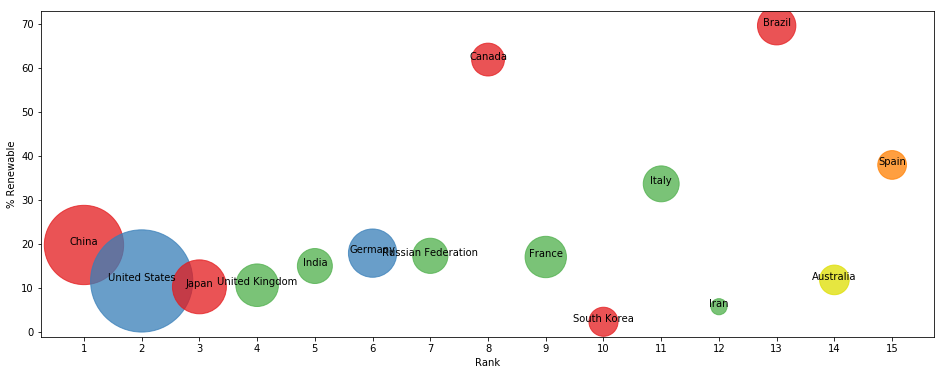

In [234]:
plot_optional() # Be sure to comment out plot_optional() before submitting the assignment!